# Sepsis-3 evaluation in the MIMIC-III database

This notebook goes over the evaluation of the new Sepsis-3 guidelines in the MIMIC database. The goals of this analysis include:

1. Evaluating the Sepsis-3 guidelines in MIMIC using the same methodology as in the research paper
2. Evaluating the Sepsis-3 guidelines against hospital mortality
3. (Appendix) Assessing if there are interesting subgroup(s) which are missed by the criteria

Here, we define Sepsis-3 using the flowchart which reproduces that from Singer et al. (2016):

![title](img/sepsis-flow.png)

We can see that the *primary* use case of Sepsis-3 is qSOFA >= 2 followed by SOFA >= 2, but this is not required to define sepsis - only SOFA >= 2 is required (where baseline SOFA is assumed to be 0 for patients - of course this may not be the case in those with chronic organ dysfunction).

In this notebook, we define Sepsis-3 as qSOFA>=2 followed by SOFA>=2 - and this allows for an illustration of the common application of the algorithm.

In [1]:
from __future__ import print_function

# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import subprocess
from collections import OrderedDict
from statsmodels.formula.api import logit
from IPython.display import display, HTML # used to print out pretty pandas dataframes

from sepsis_utils import sepsis_utils as su
from sepsis_utils import roc_utils as ru

# used to calculate AUROC/accuracy
from sklearn import metrics

# default colours for prettier plots
col = [[0.9047, 0.1918, 0.1988],
    [0.2941, 0.5447, 0.7494],
    [0.3718, 0.7176, 0.3612],
    [1.0000, 0.5482, 0.1000],
    [0.4550, 0.4946, 0.4722],
    [0.6859, 0.4035, 0.2412],
    [0.9718, 0.5553, 0.7741],
    [0.5313, 0.3359, 0.6523]];
marker = ['v','o','d','^','s','o','+']
ls = ['-','-','-','-','-','s','--','--']

%matplotlib inline

In [2]:
# load data
df = pd.read_csv('sepsis3-df.csv',sep=',')
df_mdl = pd.read_csv('sepsis3-design-matrix.csv',sep=',')

# define outcome
target_header = "hospital_expire_flag"
y = df[target_header].values == 1

# define the covariates to be added in the MFP model (used for table of AUROCs)
preds_header = ['sirs','qsofa','sofa','mlods']

# Hospital mortality evaluation

In [3]:
# define targets, angus critera
# define "predictions" according to the SEPSIS-3 guidelines:
#  suspicion of infection, qSOFA >= 2, and SOFA >= 2
# this was done in the SQL code - so we pull the values here
yhat = df.sepsis3.values

print('\n SEPSIS-3 guidelines for hospital mortality \n')
# generate evaluation metrics
print('Accuracy = {}'.format(metrics.accuracy_score(y, yhat)))

su.print_cm(y, yhat) # print confusion matrix


 SEPSIS-3 guidelines for hospital mortality 

Accuracy = 0.549808992066

Confusion matrix
      	y=0   	y=1   
yhat=0	  3072	   278	NPV=91.70
yhat=1	  2786	   670	PPV=19.39
   	52.44	70.68	Acc=54.98
   	Spec	Sens


Predictions using various levels of confounder adjustment are calculated in the subfunctions `calc_predictions`:

* `model=None` - the severity scores on their own
* `model='baseline'` - the severity scores in a vanilla regression
* `model='mfp'` -the severity scores in a fractional polynomial regression (calls an R script)

In [4]:
preds = su.calc_predictions(df, preds_header, target_header, model=None)
preds_logreg = su.calc_predictions(df, preds_header, target_header, model='logreg')
preds_mfp = su.calc_predictions(df, preds_header, target_header, model='mfp')

# also get the baseline performance of an MFP model without severity of illness
preds_mfp_baseline = su.calc_predictions(df, preds_header, target_header, model='mfp_baseline')

In [5]:
reload(su)
# reproduce the AUC table

# print out the baseline AUROC of a model without severity of illness
# in Seymour2016, this was 0.58 (validation)
auc_mfp_baseline, ci_mfp_baseline = ru.calc_auc(preds_mfp_baseline, y, with_ci=True, alpha=0.05)
print('Performance of an MFP model without severity of illness: {:0.3f} [{:0.3f}, {:0.3f}]'.format(
    auc_mfp_baseline, ci_mfp_baseline[0], ci_mfp_baseline[1]))
print('\n')

print('AUROC table for unadjusted scores:')
su.print_auc_table(preds, df[target_header].values, preds_header)
print('\n')

print('AUROC table for adjusted scores (using logistic regression):')
su.print_auc_table(preds_logreg, df[target_header].values, preds_header)
print('\n')

print('AUROC table for adjusted scores (using MFP):')
su.print_auc_table(preds_mfp, df[target_header].values, preds_header) # optional argument fixes order of output
print('\n')

su.print_auc_table_to_file(preds, df[target_header].values, preds_header=preds_header,
                           filename='auc-table-mort.csv')

su.print_auc_table_to_file(preds_mfp, df[target_header].values, preds_header=preds_header,
                           filename='auc-table-mort-mfp.csv')

Performance of an MFP model without severity of illness: 0.697 [0.680, 0.715]


AUROC table for unadjusted scores:
     	sirs                	qsofa               	sofa                	mlods               	
sirs 	0.632 [0.615, 0.650]	0.435 [0.414, 0.456]	0.179 [0.162, 0.197]	0.227 [0.207, 0.248]	
qsofa	0.173               	0.618 [0.601, 0.634]	0.270 [0.260, 0.281]	0.356 [0.344, 0.368]	
sofa 	< 0.001               	< 0.001               	0.738 [0.720, 0.756]	0.872 [0.866, 0.878]	
mlods	< 0.001               	< 0.001               	0.261               	0.745 [0.727, 0.762]	


AUROC table for adjusted scores (using logistic regression):
     	sirs                	qsofa               	sofa                	mlods               	
sirs 	0.730 [0.713, 0.746]	0.887 [0.881, 0.892]	0.709 [0.695, 0.722]	0.709 [0.695, 0.723]	
qsofa	0.038               	0.718 [0.701, 0.735]	0.763 [0.752, 0.775]	0.772 [0.760, 0.783]	
sofa 	< 0.001               	< 0.001               	0.783 [0.768, 0.799]	0.924 [0.920,

In [6]:
# print a summary of the qsofa model using logistic regression (Table 4)
print('Summary of a logistic regression model using qSOFA:')
_ = su.calc_predictions(df, ['qsofa'], target_header, model='logreg', print_summary=True)
print('\n\n')
print('Summary of a logistic regression model using qSOFA *components*:')
model = logit(formula=target_header + " ~ age + elixhauser_hospital" +
              " + race_black + race_other + is_male + " +
              " + qsofa_sysbp_score + qsofa_gcs_score + qsofa_resprate_score",
              data=df).fit(disp=0)
smry = model.summary2()
smry = smry.tables[1]
smry['Odds Ratio'] = np.exp(smry['Coef.'])

display(HTML(smry[['Coef.','Odds Ratio','P>|z|','[0.025','0.975]']].to_html()))

Summary of a logistic regression model using qSOFA:
                            Logit Regression Results                            
Dep. Variable:     hospital_expire_flag   No. Observations:                 6806
Model:                            Logit   Df Residuals:                     6799
Method:                             MLE   Df Model:                            6
Date:                  Thu, 10 Nov 2016   Pseudo R-squ.:                 0.09052
Time:                          11:42:37   Log-Likelihood:                -2498.7
converged:                         True   LL-Null:                       -2747.4
                                          LLR p-value:                3.042e-104
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              -4.1434      0.190    -21.813      0.000      -4.516      -3.771
is_male[T.True]        -0.1149      

,Coef.,Odds Ratio,P>|z|,[0.025,0.975]
Intercept,-4.466469,0.011488,1.346431e-93,-4.893024,-4.039914
race_black[T.True],-0.106647,0.898843,4.644240e-01,-0.392363,0.179069
race_other[T.True],0.448408,1.565817,9.490913e-07,0.269118,0.627698
is_male[T.True],-0.093941,0.910337,2.121790e-01,-0.241520,0.053639
age,0.016021,1.016150,8.601086e-12,0.011422,0.020620
elixhauser_hospital,0.074482,1.077326,4.120966e-44,0.064003,0.084961
qsofa_sysbp_score,0.512396,1.669286,1.194754e-10,0.356452,0.668340
qsofa_gcs_score,0.424135,1.528267,7.145781e-06,0.238964,0.609306
qsofa_resprate_score,0.913411,2.492810,9.802995e-12,0.650500,1.176321


In [7]:
# score to evaluate
score_name = "qsofa"

# below used for training MFP model... leave as default
fn_in = "sepsis3-design-matrix" # the function adds "-dev.csv" and "-val.csv"
fn_out = "sepsis3-preds"

model_covariates = ["age","elixhauser_hospital","race_black","race_other","is_male",score_name]

df_dev = pd.read_csv('sepsis3-df-dev.csv',sep=',')
df_val = pd.read_csv('sepsis3-df-val.csv',sep=',')

# build full model
formula = target_header + " ~ " + " + ".join([x for x in model_covariates])
model = logit(formula=formula,data=df_dev).fit(disp=0)
pred = model.predict(exog=df_val)

# remove all but the odds ratio column (with p value)
smry = model.summary2()
smry = smry.tables[1]
smry['Odds Ratio'] = smry.apply(lambda x: '{:1.2f}, p={:1.3f}'.format(np.exp(x['Coef.']),x['P>|z|']),axis=1)
smry.drop(['Coef.','Std.Err.','z','P>|z|','[0.025','0.975]'],inplace=True,axis=1)

# add AUROC to the bottom
auc, ci = ru.calc_auc(pred, df_val[target_header].values, with_ci=True)
smry.loc['auc','Odds Ratio'] = '{:0.2f}, {:0.2f}-{:0.2f}'.format(auc,ci[0],ci[1])

# also get performance if we were using an MFP model
formula = formula.replace(" age ", " fp(age) ").replace(" elixhauser_hospital "," fp(elixhauser_hospital) ")
formula = formula.replace(" " + score_name, " fp(" + score_name + ")")
rcmd = ["Rscript r-make-sepsis3-models-dev-val.R", fn_in, fn_out, '"' + formula + '"']
err = subprocess.call(' '.join(rcmd), shell=True)
if err!=0:
    print('RScript returned error status {}.'.format(err))

# load in the predictions
pred_val = pd.read_csv(fn_out + '-val.csv', sep=',', header=0)
pred_val = pred_val.values[:,0]
tar_val = pd.read_csv(fn_out + '-val-tar.csv', sep=',', header=0)
tar_val = tar_val.values[:,0]

auc, ci = ru.calc_auc(pred_val, tar_val, with_ci=True)

# add AUROC to the bottom
smry.loc['auc_mfp','Odds Ratio'] = '{:0.2f}, {:0.2f}-{:0.2f}'.format(auc,ci[0],ci[1])

for m in model_covariates:
    formula = target_header + " ~ " + " + ".join([x for x in model_covariates if x!=m])
    model = logit(formula=formula,data=df_dev).fit(disp=0)
    pred = model.predict(exog=df_val)
    auc, ci = ru.calc_auc(pred.values,df_val[target_header].values, with_ci=True)
    
    smry2 = model.summary2()
    smry2 = smry2.tables[1]
    smry2['Odds Ratio'] = smry2.apply(lambda x: '{:1.2f}, p={:1.3f}'.format(np.exp(x['Coef.']),x['P>|z|']),axis=1)
    smry2.loc['auc','Odds Ratio'] = '{:0.2f}, {:0.2f}-{:0.2f}'.format(auc,ci[0],ci[1])
    

    # also get performance if we were using an MFP model
    formula = formula.replace(" age ", " fp(age) ").replace(" elixhauser_hospital "," fp(elixhauser_hospital) ")
    formula = formula.replace(" " + score_name, " fp(" + score_name + ")")
    rcmd = ["Rscript r-make-sepsis3-models-dev-val.R", fn_in, fn_out, '"' + formula + '"']
    err = subprocess.call(' '.join(rcmd), shell=True)
    if err!=0:
        print('RScript returned error status {}.'.format(err))

    # load in the predictions
    pred_val = pd.read_csv(fn_out + '-val.csv', sep=',', header=0)
    pred_val = pred_val.values[:,0]
    tar_val = pd.read_csv(fn_out + '-val-tar.csv', sep=',', header=0)
    tar_val = tar_val.values[:,0]

    smry2.loc['auc_mfp','Odds Ratio'] = '{:0.2f}, {:0.2f}-{:0.2f}'.format(auc,ci[0],ci[1])
    
    # add this as another column of smry
    smry.loc[smry2.index,m] = smry2['Odds Ratio']
    
    
display(HTML(smry.to_html().replace('NaN','')))

,Odds Ratio,age,elixhauser_hospital,race_black,race_other,is_male,qsofa
Intercept,"0.01, p=0.000","0.04, p=0.000","0.01, p=0.000","0.01, p=0.000","0.02, p=0.000","0.01, p=0.000","0.03, p=0.000"
race_black[T.True],"0.95, p=0.799","0.88, p=0.515","1.04, p=0.857",,"0.84, p=0.368","0.96, p=0.821","0.99, p=0.975"
race_other[T.True],"1.70, p=0.000","1.57, p=0.000","1.71, p=0.000","1.71, p=0.000",,"1.70, p=0.000","1.71, p=0.000"
is_male[T.True],"0.93, p=0.473","0.87, p=0.182","0.98, p=0.863","0.93, p=0.479","0.93, p=0.485",,"0.92, p=0.406"
age,"1.02, p=0.000",,"1.02, p=0.000","1.02, p=0.000","1.01, p=0.000","1.02, p=0.000","1.02, p=0.000"
elixhauser_hospital,"1.08, p=0.000","1.09, p=0.000",,"1.08, p=0.000","1.08, p=0.000","1.08, p=0.000","1.08, p=0.000"
qsofa,"1.79, p=0.000","1.89, p=0.000","1.86, p=0.000","1.79, p=0.000","1.79, p=0.000","1.79, p=0.000",
auc,"0.70, 0.68-0.73","0.69, 0.67-0.72","0.65, 0.62-0.67","0.70, 0.68-0.73","0.70, 0.68-0.73","0.70, 0.68-0.73","0.69, 0.67-0.72"
auc_mfp,"0.70, 0.68-0.73","0.69, 0.67-0.72","0.65, 0.62-0.67","0.70, 0.68-0.73","0.70, 0.68-0.73","0.70, 0.68-0.73","0.69, 0.67-0.72"


In [8]:
# score to evaluate
score_name = "sofa"

# below used for training MFP model... leave as default
fn_in = "sepsis3-design-matrix" # the function adds "-dev.csv" and "-val.csv"
fn_out = "sepsis3-preds"

model_covariates = ["age","elixhauser_hospital","race_black","race_other","is_male",score_name]

df_dev = pd.read_csv('sepsis3-df-dev.csv',sep=',')
df_val = pd.read_csv('sepsis3-df-val.csv',sep=',')

# build full model
formula = target_header + " ~ " + " + ".join([x for x in model_covariates])
model = logit(formula=formula,data=df_dev).fit(disp=0)
pred = model.predict(exog=df_val)

# remove all but the odds ratio column (with p value)
smry = model.summary2()
smry = smry.tables[1]
smry['Odds Ratio'] = smry.apply(lambda x: '{:1.2f}, p={:1.3f}'.format(np.exp(x['Coef.']),x['P>|z|']),axis=1)
smry.drop(['Coef.','Std.Err.','z','P>|z|','[0.025','0.975]'],inplace=True,axis=1)

# add AUROC to the bottom
auc, ci = ru.calc_auc(pred, df_val[target_header].values, with_ci=True)
smry.loc['auc','Odds Ratio'] = '{:0.2f}, {:0.2f}-{:0.2f}'.format(auc,ci[0],ci[1])

# also get performance if we were using an MFP model
formula = formula.replace(" age ", " fp(age, df=4) ").replace(" elixhauser_hospital "," fp(elixhauser_hospital, df=4) ")
formula = formula.replace(" " + score_name, " fp(" + score_name + ", df=4)")
rcmd = ["Rscript r-make-sepsis3-models-dev-val.R", fn_in, fn_out, '"' + formula + '"']
err = subprocess.call(' '.join(rcmd), shell=True)
if err!=0:
    print('RScript returned error status {}.'.format(err))

# load in the predictions
pred_val = pd.read_csv(fn_out + '-val.csv', sep=',', header=0)
pred_val = pred_val.values[:,0]
tar_val = pd.read_csv(fn_out + '-val-tar.csv', sep=',', header=0)
tar_val = tar_val.values[:,0]

auc, ci = ru.calc_auc(pred_val, tar_val, with_ci=True)

# add AUROC to the bottom
smry.loc['auc_mfp','Odds Ratio'] = '{:0.2f}, {:0.2f}-{:0.2f}'.format(auc,ci[0],ci[1])

for m in model_covariates:
    formula = target_header + " ~ " + " + ".join([x for x in model_covariates if x!=m])
    model = logit(formula=formula,data=df_dev).fit(disp=0)
    pred = model.predict(exog=df_val)
    auc, ci = ru.calc_auc(pred.values,df_val[target_header].values, with_ci=True)
    
    smry2 = model.summary2()
    smry2 = smry2.tables[1]
    smry2['Odds Ratio'] = smry2.apply(lambda x: '{:1.2f}, p={:1.3f}'.format(np.exp(x['Coef.']),x['P>|z|']),axis=1)
    smry2.loc['auc','Odds Ratio'] = '{:0.2f}, {:0.2f}-{:0.2f}'.format(auc,ci[0],ci[1])
    

    # also get performance if we were using an MFP model
    formula = formula.replace(" age ", " fp(age, df=4) ").replace(" elixhauser_hospital "," fp(elixhauser_hospital, df=4) ")
    formula = formula.replace(" " + score_name, " fp(" + score_name + ", df=4)")
    rcmd = ["Rscript r-make-sepsis3-models-dev-val.R", fn_in, fn_out, '"' + formula + '"']
    err = subprocess.call(' '.join(rcmd), shell=True)
    if err!=0:
        print('RScript returned error status {}.'.format(err))

    # load in the predictions
    pred_val = pd.read_csv(fn_out + '-val.csv', sep=',', header=0)
    pred_val = pred_val.values[:,0]
    tar_val = pd.read_csv(fn_out + '-val-tar.csv', sep=',', header=0)
    tar_val = tar_val.values[:,0]

    smry2.loc['auc_mfp','Odds Ratio'] = '{:0.2f}, {:0.2f}-{:0.2f}'.format(auc,ci[0],ci[1])
    
    # add this as another column of smry
    smry.loc[smry2.index,m] = smry2['Odds Ratio']
    
    
display(HTML(smry.to_html().replace('NaN','')))

,Odds Ratio,age,elixhauser_hospital,race_black,race_other,is_male,sofa
Intercept,"0.01, p=0.000","0.03, p=0.000","0.01, p=0.000","0.01, p=0.000","0.01, p=0.000","0.01, p=0.000","0.03, p=0.000"
race_black[T.True],"0.91, p=0.635","0.85, p=0.410","0.98, p=0.901",,"0.82, p=0.319","0.92, p=0.682","0.99, p=0.975"
race_other[T.True],"1.57, p=0.001","1.43, p=0.006","1.58, p=0.001","1.59, p=0.000",,"1.57, p=0.001","1.71, p=0.000"
is_male[T.True],"0.83, p=0.085","0.77, p=0.014","0.86, p=0.181","0.83, p=0.088","0.83, p=0.083",,"0.92, p=0.406"
age,"1.02, p=0.000",,"1.02, p=0.000","1.02, p=0.000","1.02, p=0.000","1.02, p=0.000","1.02, p=0.000"
elixhauser_hospital,"1.06, p=0.000","1.07, p=0.000",,"1.06, p=0.000","1.06, p=0.000","1.06, p=0.000","1.08, p=0.000"
sofa,"1.27, p=0.000","1.27, p=0.000","1.29, p=0.000","1.27, p=0.000","1.27, p=0.000","1.27, p=0.000",
auc,"0.78, 0.75-0.80","0.76, 0.74-0.79","0.76, 0.74-0.78","0.78, 0.75-0.80","0.78, 0.75-0.80","0.78, 0.75-0.80","0.69, 0.67-0.72"
auc_mfp,"0.78, 0.75-0.80","0.76, 0.74-0.79","0.76, 0.74-0.78","0.78, 0.75-0.80","0.78, 0.75-0.80","0.78, 0.75-0.80","0.69, 0.67-0.72"


## ROC curves

### Unadjusted ROC

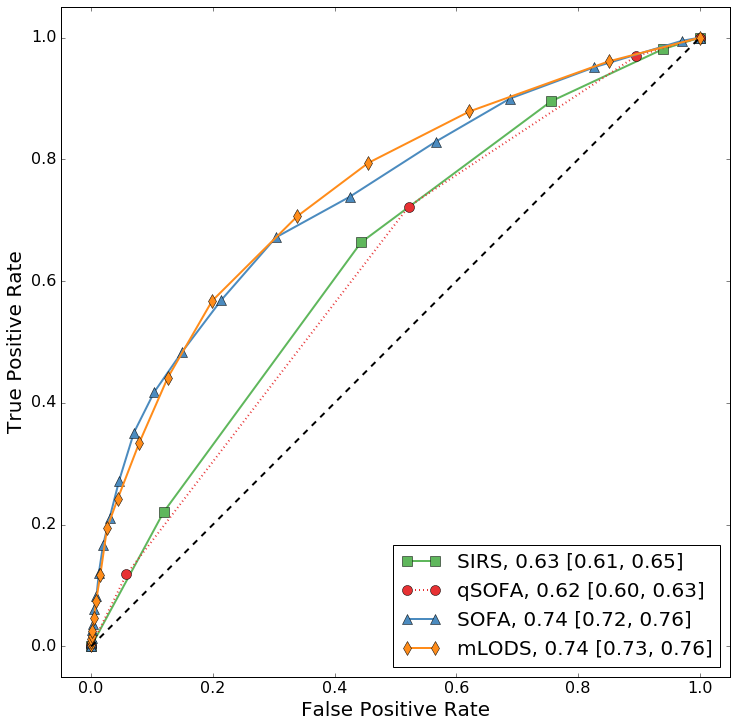

In [9]:
markers = {'qsofa': 'o:', 'sofa': '^-', 'sirs': 's-', 'mlods': 'd-'}
colors = {'qsofa': col[0], 'sofa': col[1], 'sirs': col[2], 'mlods': col[3]}
pred_pretty_text = {'qsofa': 'qSOFA', 'sofa': 'SOFA', 'sirs': 'SIRS', 'mlods': 'mLODS'}
# plot the data
ax = plt.figure(figsize=[12,12]).add_subplot(111)

# ROC for each score in preds header
for pred in preds_header:
    fpr, tpr, thr = metrics.roc_curve(y, df[pred].values)
    auc, auc_ci = ru.calc_auc(df[pred].values, y, with_ci=True, alpha=0.05)
    
    plt.plot(fpr, tpr, markers[pred],
             color=colors[pred], linewidth=2, markersize=10,
             label=pred_pretty_text[pred] + ', ' +
             '{:0.2f} [{:0.2f}, {:0.2f}]'.format(auc, auc_ci[0], auc_ci[1]))

plt.legend(loc="lower right", fontsize=20)

plt.plot([0,1], [0,1], '--',
         color=[0,0,0], linewidth=2)

# reformat the plot
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate',fontsize=20)
plt.ylabel('True Positive Rate',fontsize=20)

for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(16) 
    
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(16) 
#plt.title('ROC against in-hospital mortality',fontsize=14)
plt.show()

### Scores after adjusting in MFP model

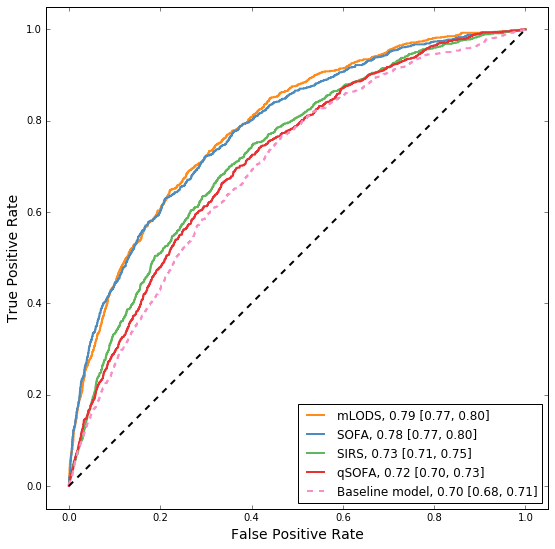

In [10]:

markers = {'qsofa': '-', 'sofa': '-', 'sirs': '-', 'mlods': '-'}
colors = {'qsofa': col[0], 'sofa': col[1], 'sirs': col[2], 'mlods': col[3]}
pred_pretty_text = OrderedDict([['mlods', 'mLODS'],
                               ['sofa', 'SOFA'],
                               ['sirs', 'SIRS'],
                               ['qsofa', 'qSOFA']])
# plot the data
plt.figure(figsize=[9,9])


# ROC for each score in preds header
for pred in pred_pretty_text:
    fpr, tpr, thr = metrics.roc_curve(y, preds_mfp[pred])
    auc, auc_ci = ru.calc_auc(preds_mfp[pred], y, with_ci=True, alpha=0.05)
    
    plt.plot(fpr, tpr, markers[pred],
             color=colors[pred], linewidth=2, markersize=10,
             label=pred_pretty_text[pred] + ', ' +
             '{:0.2f} [{:0.2f}, {:0.2f}]'.format(auc, auc_ci[0], auc_ci[1]))


# baseline MFP model
fpr, tpr, thr = metrics.roc_curve(y, preds_mfp_baseline)
auc, auc_ci = ru.calc_auc(preds_mfp_baseline, y, with_ci=True, alpha=0.05)
    
plt.plot(fpr, tpr, '--',
         color=col[6], linewidth=2, markersize=10,
         label='Baseline model, {:0.2f} [{:0.2f}, {:0.2f}]'.format(auc, auc_ci[0], auc_ci[1]))
plt.legend(loc="lower right")

plt.plot([0,1], [0,1], '--',
         color=[0,0,0], linewidth=2)
# reformat the plot
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate',fontsize=14)
plt.ylabel('True Positive Rate',fontsize=14)
#plt.title('ROC against in-hospital mortality',fontsize=14)
plt.show()

## Operating point statistics

This section evaluates the standard operating point statistics:

* sensitivity (% of true positives which are correctly classified)
* specificity (% of true negatives which are correctly classified)
* positive predictive value (given a positive prediction is made, what % are correct)
* negative predictive value (given a negative prediction is made, what % are correct)
* F1 score (harmonic mean of sensitivity and PPV)

In [11]:
# define "predictions" according to the SEPSIS-3 guidelines:
#  suspicion of infection, qSOFA >= 2, and SOFA >= 2
yhat_all = [df.sirs.values >= 2,
            df.qsofa.values >= 2,
            df.sofa.values >= 2,
            df.sepsis3.values,
            df.mlods.values >= 2]
yhat_names = ['SIRS', 'qsofa', 'sofa', 'seps3', 'mLODS']

# define "targets", angus critera
y_all = [y for x in yhat_names]

stats_all = su.get_op_stats(yhat_all, y_all,
               yhat_names=yhat_names,
               header=target_header)

In addition, we evaluate the number of false positives per 100 cases, or NFP/100. We feel this gives helpful perspective in interpretting the positive predictive value of the prediction and its relationship to the prevalance of the outcome. In this context, the measure can be summarized as: given 100 patients with suspected infection, how many will each algorithm inappropriately give a positive prediction?

In [12]:
# example of NFP/100
N_PATIENTS = 100
score_name = 'sofa'

idxScore = np.where([x==score_name for x in yhat_names])[0][0]
score_pos = (stats_all[idxScore,1]+stats_all[idxScore,3])/np.sum(stats_all[idxScore,0:4])
score_ppv = stats_all[idxScore,6]/100.0

N_POSITIVES = N_PATIENTS*score_pos
print('For {:2.2f} patients, {:2.2f} positives.'.format(N_PATIENTS, N_POSITIVES))
print('Of the {:2.2f} positives, {:2.2f} are false.'.format(N_POSITIVES, N_POSITIVES*(1-score_ppv)))

For 100.00 patients, 84.43 positives.
Of the 84.43 positives, 71.17 are false.


A similar question can be asked: given 100 patients with suspected infection, how many will each algorithm  appropriately give a positive prediction?

In [13]:
# example of NTP/100
N_PATIENTS = 100
score_name = 'sofa'

idxScore = np.where([x==score_name for x in yhat_names])[0][0]
score_pos = (stats_all[idxScore,1]+stats_all[idxScore,3])/np.sum(stats_all[idxScore,0:4])
score_ppv = stats_all[idxScore,6]/100.0

N_POSITIVES = N_PATIENTS*score_pos
print('For {:2.2f} patients, {:2.2f} positives.'.format(N_PATIENTS, N_POSITIVES))
print('Of the {:2.2f} positives, {:2.2f} are true.'.format(N_POSITIVES, N_POSITIVES*(score_ppv)))

For 100.00 patients, 84.43 positives.
Of the 84.43 positives, 13.25 are true.


In [14]:
print('\nRepeating the above for all scores...')
print('\nscore\tNTP/100\tNFP/100')
for score_name in yhat_names:
    idxScore = np.where([x==score_name for x in yhat_names])[0][0]
    score_pos = (stats_all[idxScore,1]+stats_all[idxScore,3])/np.sum(stats_all[idxScore,0:4])
    score_ppv = stats_all[idxScore,6]/100.0

    N_POSITIVES = N_PATIENTS*score_pos
    print('{:5s}\t{:2.2f}\t{:2.2f}'.format(score_name, N_POSITIVES*(score_ppv), N_POSITIVES*(1-score_ppv)))


Repeating the above for all scores...

score	NTP/100	NFP/100
SIRS 	12.47	65.06
qsofa	10.06	44.90
sofa 	13.25	71.17
seps3	9.84	40.93
mLODS	12.24	53.48


Now we print out all the operating point statistics.

In [15]:
su.print_op_stats(stats_all,
               yhat_names=yhat_names,
               header=target_header)

Metric


     	SIRS                	qsofa               	sofa                	seps3               	mLODS               
TN   	 1430           	 2802           	 1014           	 3072           	 2218           
FP   	 4428           	 3056           	 4844           	 2786           	 3640           
FN   	   99           	  263           	   46           	  278           	  115           
TP   	  849           	  685           	  902           	  670           	  833           
Sens 	89.56 [0.87, 0.91]	72.26 [0.69, 0.75]	95.15 [0.94, 0.96]	70.68 [0.68, 0.74]	87.87 [0.86, 0.90]
Spec 	24.41 [0.23, 0.26]	47.83 [0.47, 0.49]	17.31 [0.16, 0.18]	52.44 [0.51, 0.54]	37.86 [0.37, 0.39]
PPV  	16.09 [0.15, 0.17]	18.31 [0.17, 0.20]	15.70 [0.15, 0.17]	19.39 [0.18, 0.21]	18.62 [0.17, 0.20]
NPV  	93.53 [0.92, 0.95]	91.42 [0.90, 0.92]	95.66 [0.94, 0.97]	91.70 [0.91, 0.93]	95.07 [0.94, 0.96]
F1   	27.28             	29.22             	26.95             	30.43             	30.73             
NTP  	12.47

In [16]:
print('score\tNNH')
for score_name in yhat_names:
    idxScore = np.where([x==score_name for x in yhat_names])[0][0]
    p_death_no_flag = np.mean(y[yhat_all[idxScore]==False])
    p_death_ys_flag = np.mean(y[yhat_all[idxScore]==True])
    NNT = 1/(p_death_ys_flag - p_death_no_flag)
    
    print('{:5s}\t{:2.2f}'.format(score_name, NNT))

score	NNH
SIRS 	10.40
qsofa	10.28
sofa 	8.80
seps3	9.02
mLODS	7.30


# Appendix

## Evaluating the MFP model in a derivation/validation setting

In [17]:
# baseline model
fn_in = "sepsis3-design-matrix" # the function adds "-dev.csv" and "-val.csv"
fn_out = "sepsis3-preds"

# by excluding the 4th argument, we train a baseline MFP model
formula = target_header + " ~ fp(age) + fp(elixhauser_hospital) + is_male + race_black + race_other"
rcmd = ["Rscript r-make-sepsis3-models-dev-val.R", fn_in, fn_out, '"' + formula + '"']
err = subprocess.call(' '.join(rcmd), shell=True)
if err!=0:
    print('RScript returned error status {}.'.format(err))
else:
    # load in the predictions
    pred_dev = pd.read_csv(fn_out + '-dev.csv', sep=',', header=0)
    pred_dev = pred_dev.values[:,0]
    
    pred_val = pd.read_csv(fn_out + '-val.csv', sep=',', header=0)
    pred_val = pred_val.values[:,0]
    
    # read in the targets
    tar_dev = pd.read_csv(fn_out + '-dev-tar.csv', sep=',', header=0)
    tar_dev = tar_dev.values[:,0]
    
    tar_val = pd.read_csv(fn_out + '-val-tar.csv', sep=',', header=0)
    tar_val = tar_val.values[:,0]
    
# print out the baseline AUROC of a model without severity of illness
# in Seymour2016, this was 0.58 (validation)
auc_mfp_dev, ci_mfp_dev = ru.calc_auc(pred_dev, tar_dev, with_ci=True, alpha=0.05)
auc_mfp_val, ci_mfp_val = ru.calc_auc(pred_val, tar_val, with_ci=True, alpha=0.05)


print('Performance of an MFP model without severity of illness.')
print('DEV: {:0.3f} [{:0.3f}, {:0.3f}]'.format(
        auc_mfp_dev, ci_mfp_dev[0], ci_mfp_dev[1]))
print('VAL: {:0.3f} [{:0.3f}, {:0.3f}]'.format(
        auc_mfp_val, ci_mfp_val[0], ci_mfp_val[1]))
print('\n')

Performance of an MFP model without severity of illness.
DEV: 0.703 [0.678, 0.727]
VAL: 0.691 [0.666, 0.716]




## Comparing binormal and empirical ROC

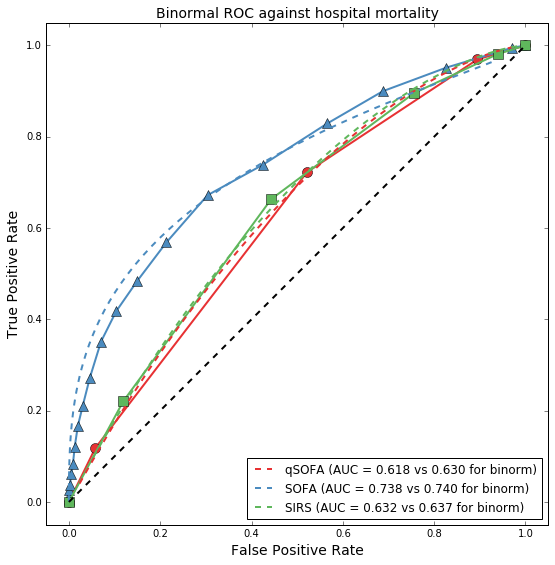

In [18]:
y = df.hospital_expire_flag.values == 1
plt.figure(figsize=[9,9])

# === NORMAL EMPIRICALLY DERIVED ROC

# ROC for qSOFA
fpr_qsofa, tpr_qsofa, thresholds_qsofa = metrics.roc_curve(y, df.qsofa.values)
auc_qsofa = metrics.auc(fpr_qsofa, tpr_qsofa)

# ROC for SOFA
fpr_sofa, tpr_sofa, thresholds_sofa = metrics.roc_curve(y, df.sofa.values)
auc_sofa = metrics.auc(fpr_sofa, tpr_sofa)


# ROC for SEPSIS-3
fpr_s3, tpr_s3, thresholds_s3 = metrics.roc_curve(y, (df.qsofa.values >= 2) & (df.sofa.values >= 2))
auc_s3 = metrics.auc(fpr_s3, tpr_s3)

# ROC for SIRS
fpr_sirs, tpr_sirs, thresholds_sirs = metrics.roc_curve(y, df.sirs.values)
auc_sirs = metrics.auc(fpr_sirs, tpr_sirs)

# plot the data
plt.plot(fpr_qsofa, tpr_qsofa, 'o-',
         color=col[0], linewidth=2, markersize=10)
plt.plot(fpr_sofa, tpr_sofa, '^-',
         color=col[1], linewidth=2, markersize=10)
plt.plot(fpr_sirs, tpr_sirs, 's-',
         color=col[2], linewidth=2, markersize=10)


# === BINORMAL ESTIMATED ROC

# ROC for qSOFA
fpr_qsofa, tpr_qsofa, thresholds_qsofa = ru.binormal_roc(df.qsofa.values[y], df.qsofa.values[~y])
auc_qsofa2 = ru.binormal_auroc(df.qsofa.values[y], df.qsofa.values[~y])

# ROC for SOFA
fpr_sofa, tpr_sofa, thresholds_sofa = ru.binormal_roc(df.sofa.values[y], df.sofa.values[~y])
auc_sofa2 = ru.binormal_auroc(df.sofa.values[y], df.sofa.values[~y])

# ROC for SIRS
fpr_sirs, tpr_sirs, thresholds_sirs = ru.binormal_roc(df.sirs.values[y], df.sirs.values[~y])
auc_sirs2 = ru.binormal_auroc(df.sirs.values[y], df.sirs.values[~y])

# plot the data
plt.plot(fpr_qsofa, tpr_qsofa, '--',
         color=col[0], linewidth=2, markersize=10,
         label='qSOFA (AUC = {:0.3f} vs {:0.3f} for binorm)'.format(auc_qsofa, auc_qsofa2))
plt.plot(fpr_sofa, tpr_sofa, '--',
         color=col[1], linewidth=2, markersize=10,
         label='SOFA (AUC = {:0.3f} vs {:0.3f} for binorm)'.format(auc_sofa, auc_sofa2))
plt.plot(fpr_sirs, tpr_sirs, '--',
         color=col[2], linewidth=2, markersize=10,
         label='SIRS (AUC = {:0.3f} vs {:0.3f} for binorm)'.format(auc_sirs, auc_sirs2))

plt.legend(loc="lower right")

plt.plot([0,1], [0,1], '--',
         color=[0,0,0], linewidth=2)
# reformat the plot
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate',fontsize=14)
plt.ylabel('True Positive Rate',fontsize=14)
plt.title('Binormal ROC against hospital mortality',fontsize=14)
plt.show()

## Histograms comparing qSOFA in septic/non-septic population

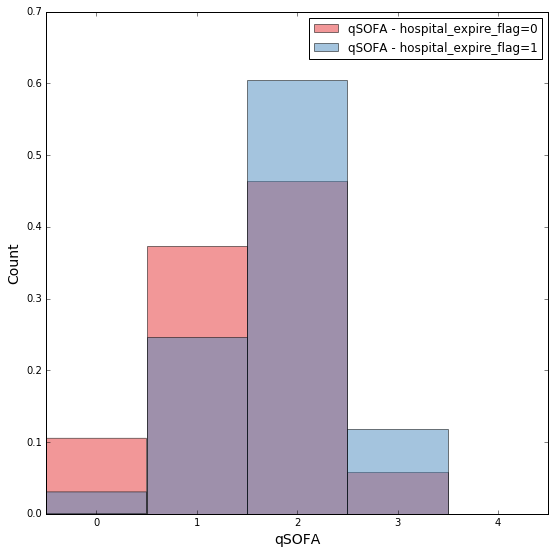

In [19]:
# histogram of the qSOFA values in septic/non-septic population
y = df.hospital_expire_flag.values == 1

qsofa_alive = df.qsofa.values[~y]
qsofa_dead = df.qsofa.values[y]

xi = [-0.5,0.5,1.5,2.5,3.5]

# plot the data
plt.figure(figsize=[9,9])
plt.hist(qsofa_alive, bins=xi, normed=True, color=col[0], alpha=0.5,
         label='qSOFA - ' + target_header + '=0')
plt.hist(qsofa_dead, bins=xi, normed=True, color=col[1], alpha=0.5,
         label='qSOFA - ' + target_header + '=1')

plt.legend(loc="upper right")

# reformat the plot
plt.xlim([-0.5,4.5])
#plt.ylim([-0.05, 1.05])
plt.xlabel('qSOFA',fontsize=14)
plt.ylabel('Count',fontsize=14)
plt.show()

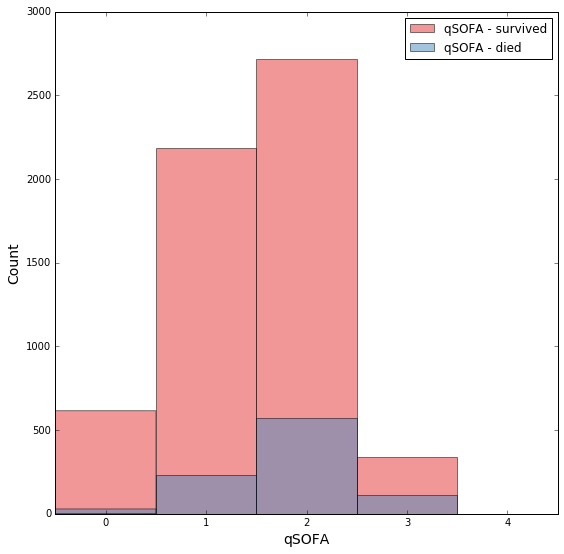

In [20]:
# histogram of the qSOFA values in septic/non-septic population
y = df.hospital_expire_flag.values == 1

qsofa_alive = df.qsofa.values[~y]
qsofa_dead = df.qsofa.values[y]

xi = [-0.5,0.5,1.5,2.5,3.5]

prevalence = np.mean(y)

# plot the data
plt.figure(figsize=[9,9])
n0, bins0, patches0 = plt.hist(qsofa_alive, bins=xi, normed=False, color=col[0], alpha=0.5,
         label='qSOFA - survived')
n1, bins1, patches1 = plt.hist(qsofa_dead, bins=xi, normed=False, color=col[1], alpha=0.5,
         label='qSOFA - died')

plt.legend(loc="upper right")

# reformat the plot
plt.xlim([-0.5,4.5])
#plt.ylim([-0.05, 1.05])
plt.xlabel('qSOFA',fontsize=14)
plt.ylabel('Count',fontsize=14)
#plt.title('ROC against hospital mortality',fontsize=14)
plt.show()

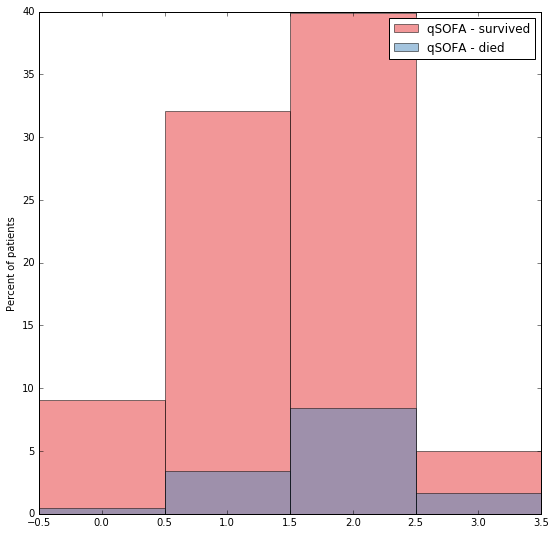

In [21]:
plt.figure(figsize=[9,9])

N = len(y)
plt.bar(bins0[0:-1], 100.0*n0/N, width=1, color=col[0], alpha=0.5,
         label='qSOFA - survived')
plt.bar(bins1[0:-1], 100.0*n1/N, width=1, color=col[1], alpha=0.5,
         label='qSOFA - died')
plt.legend()
plt.ylabel('Percent of patients')
plt.show()